## Methodology for IDS

## Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html.

Due to the large size of this dataset, sampled subsets of CICIDS2017 are used in this project. These subsets are located in the "data" folder.
If you wish to apply this code to other datasets (e.g., the CAN-intrusion dataset), simply update the dataset path and follow the same steps. The models implemented in this code are generic and can be applied to any intrusion detection or network traffic dataset.

In [ ]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017.csv')


In [ ]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,32215,4,2,112,152,28,28,28.0,0.00000,76,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,324,2,2,84,362,42,42,42.0,0.00000,181,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,82,2,1,31,6,31,0,15.5,21.92031,6,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,1048635,6,2,192,256,32,32,32.0,0.00000,128,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.Label.value_counts()

BENIGN          2273097
DoS              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [ ]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [ ]:
df.Label.value_counts()

0    2273097
3     380699
5     158930
2      13835
6       2180
1       1966
4         36
Name: Label, dtype: int64

In [ ]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [ ]:
X = df_major.drop(['Label'],axis=1)
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [ ]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [ ]:
df_major['klabel'].value_counts()

318    22146
2      20340
258    20225
308    18461
432    18154
       ...  
366       70
92        21
596       14
756       10
295        3
Name: klabel, Length: 997, dtype: int64

In [ ]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [ ]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,391,0
1,-0.439344,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,498,0
2,-0.439345,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,499,0
3,-0.439346,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,787,0
4,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,391,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,-0.438390,-0.007151,-0.008416,-0.043758,-0.007075,-0.250424,0.153902,-0.162296,-0.245069,-0.408376,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,813,0
2830739,-0.439337,-0.009819,-0.008416,-0.046560,-0.006982,-0.230903,0.385923,-0.087065,-0.245069,-0.354429,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,916,0
2830740,-0.439344,-0.009819,-0.009418,-0.051863,-0.007139,-0.246240,-0.310140,-0.229468,-0.167112,-0.444340,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,267,0
2830741,-0.408187,-0.004484,-0.008416,-0.035753,-0.007029,-0.244846,0.220194,-0.140802,-0.245069,-0.381659,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,634,0


In [ ]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [ ]:
result['Label'].value_counts()

0    18185
3     3029
5     1280
2      118
Name: Label, dtype: int64

In [ ]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
6980,-0.437857,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1506627,-0.438252,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
1377524,-0.438860,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
2056871,-0.435684,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
2005567,-0.437738,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031173,-0.438439,-0.011153,-0.009418,-0.050963,-0.007110,-0.233691,0.352777,-0.097812,-0.245069,-0.410431,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
1608048,-0.438422,-0.009819,-0.008416,-0.047160,-0.007083,-0.235086,0.336204,-0.103186,-0.245069,-0.413000,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
817023,-0.437935,-0.011153,-0.009418,-0.050863,-0.007108,-0.232297,0.369350,-0.092438,-0.245069,-0.408376,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0
559006,-0.437946,-0.011153,-0.009418,-0.050763,-0.007111,-0.230903,0.385923,-0.087065,-0.245069,-0.411459,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,999,0


In [ ]:
result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

In [ ]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### Preprocessing (normalization and padding values)

In [ ]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

### split train set and test set

In [ ]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

### Feature selection by information gain

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [ ]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [ ]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break

In [ ]:
X_fs = df[fs].values

In [ ]:
X_fs.shape

(26800, 44)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [ ]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [ ]:
X_fss = fcbf.fit_transform(X_fs,y)

In [ ]:
X_fss.shape

(26800, 20)

### Re-split train & test sets after feature selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(21440, 20)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers 0,1,2,...
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Check the distribution again
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
2       77
4       29
Name: count, dtype: int64

In [ ]:
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
2       77
4       29
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
4     1000
2     1000
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9901119402985075
Precision of XGBoost: 0.9902126542611857
Recall of XGBoost: 0.9901119402985075
F1-score of XGBoost: 0.9901358744111337
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.98      0.98      0.98       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.71      0.71      0.71         7
           5       0.98      1.00      0.99       251
           6       0.96      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.95      0.95      0.95      5360
weighted avg       0.99      0.99      0.99      5360



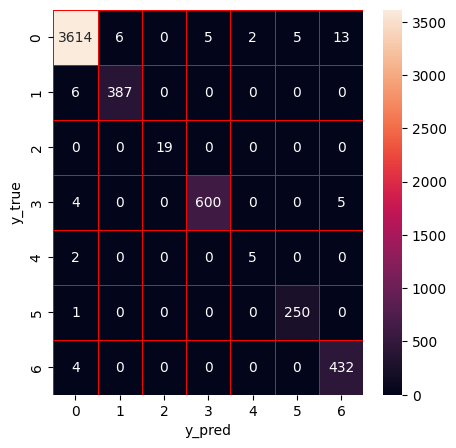

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:33<00:00,  1.68s/trial, best loss: -0.996455223880597]
XGBoost: Hyperopt estimated optimum {'learning_rate': -1.3750371241260422, 'max_depth': 13.0, 'n_estimators': 25.0}


Accuracy of XGBoost: 0.9960820895522388
Precision of XGBoost: 0.996062624085396
Recall of XGBoost: 0.9960820895522388
F1-score of XGBoost: 0.9960629666099937
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       0.83      0.71      0.77         7
           5       0.99      1.00      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5360
   macro avg       0.97      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



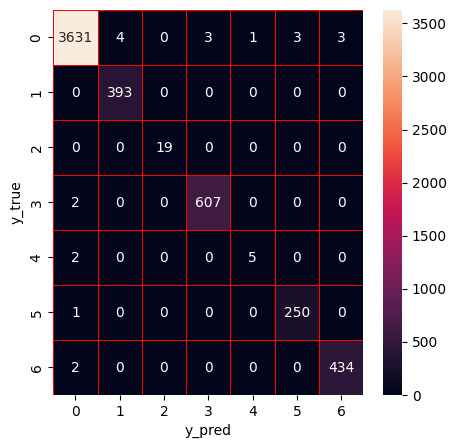

In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)